# 사람의 동작 분류
- 핸드폰 센서 데이터 분류
- 선형 모델, 랜덤포레스트, MLP, CNN, RNN 비교
- colab에서 실행해야 함 (keras 등 설치 필요)
 - 런타임 유형변경 - GPU로

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import np_utils
%config InlineBackend.figure_format = 'retina'

In [2]:
!curl https://raw.githubusercontent.com/StillWork/data/master/smartphone_human.txt.zip\
    -o smartphone_human.txt.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.5M  100 10.5M    0     0  6842k      0  0:00:01  0:00:01 --:--:-- 6842k


In [3]:
!unzip -o smartphone_human.txt.zip

Archive:  smartphone_human.txt.zip
  inflating: smartphone_human.txt    
   creating: __MACOSX/
  inflating: __MACOSX/._smartphone_human.txt  


In [4]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [5]:
!head -5 smartphone_human.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [6]:
column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 
                'y-axis', 'z-axis']
df = pd.read_csv('smartphone_human.txt', header=None, names=column_names)

In [7]:
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x-axis     1098204 non-null  float64
 4   y-axis     1098204 non-null  float64
 5   z-axis     1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 50.3+ MB


In [9]:
# 1개의 결측치를 제거한다
# z-컬럼의 ';'를 삭제하고 문자열 타입을 숫자 타입으로 변경한다 
df['z-axis'].replace(regex=True,inplace=True, to_replace=r';', value=r'')
df['z-axis'] = df['z-axis'].apply(np.float)
df.dropna(axis=0, how='any', inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [10]:
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722


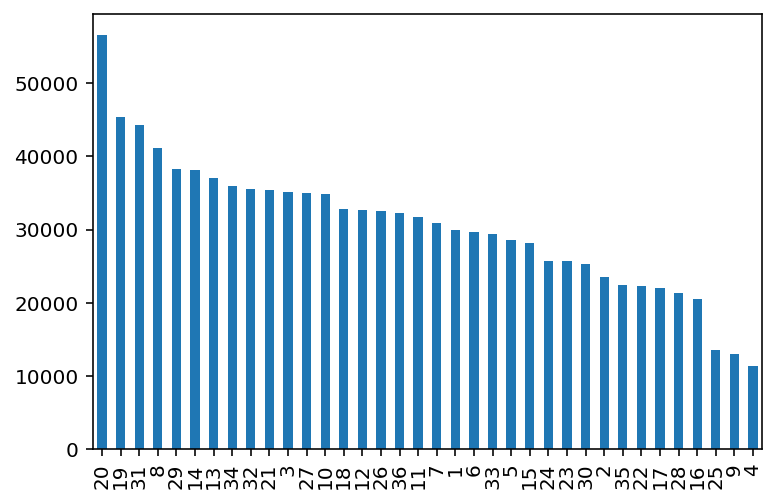

In [11]:
# 사용자별 데이터 수집량 보기
df['user-id'].value_counts().plot(kind='bar')

In [12]:
df["user-id"].nunique()

36

In [13]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

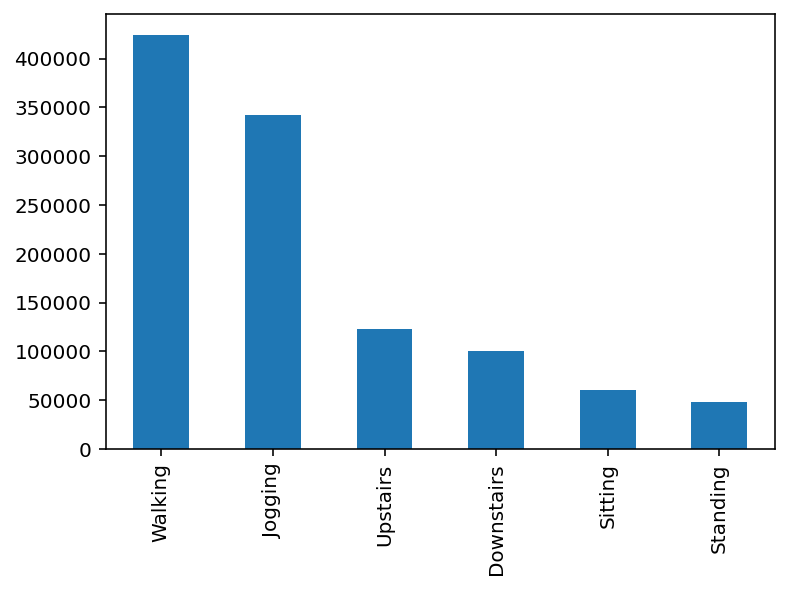

In [14]:
df['activity'].value_counts().plot(kind='bar')
plt.show()

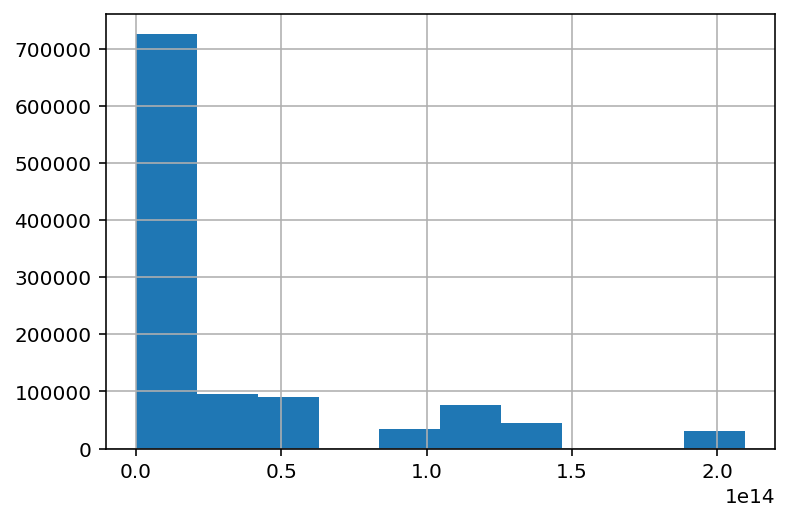

In [15]:
df['timestamp'].hist()

In [16]:
(df['timestamp'] == 0).sum()

12843

In [17]:
# 시각이 0이거나 음수인 샘플은 제외 (양수인 값만 사용)
df = df[df['timestamp'] > 0]
df.shape

(1085360, 6)

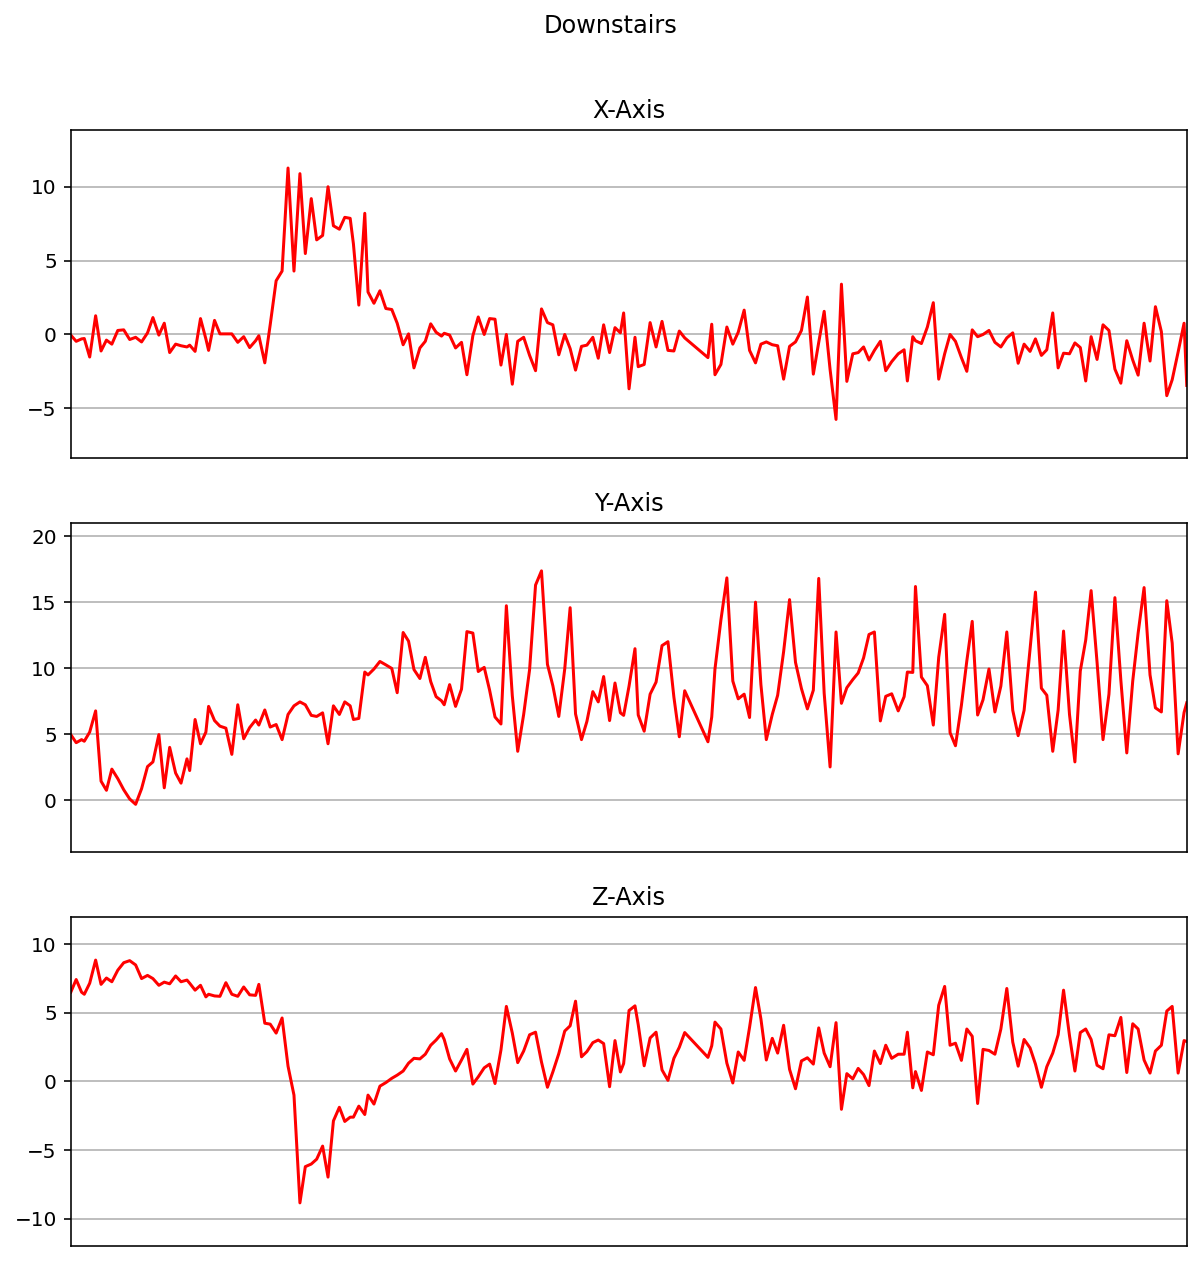

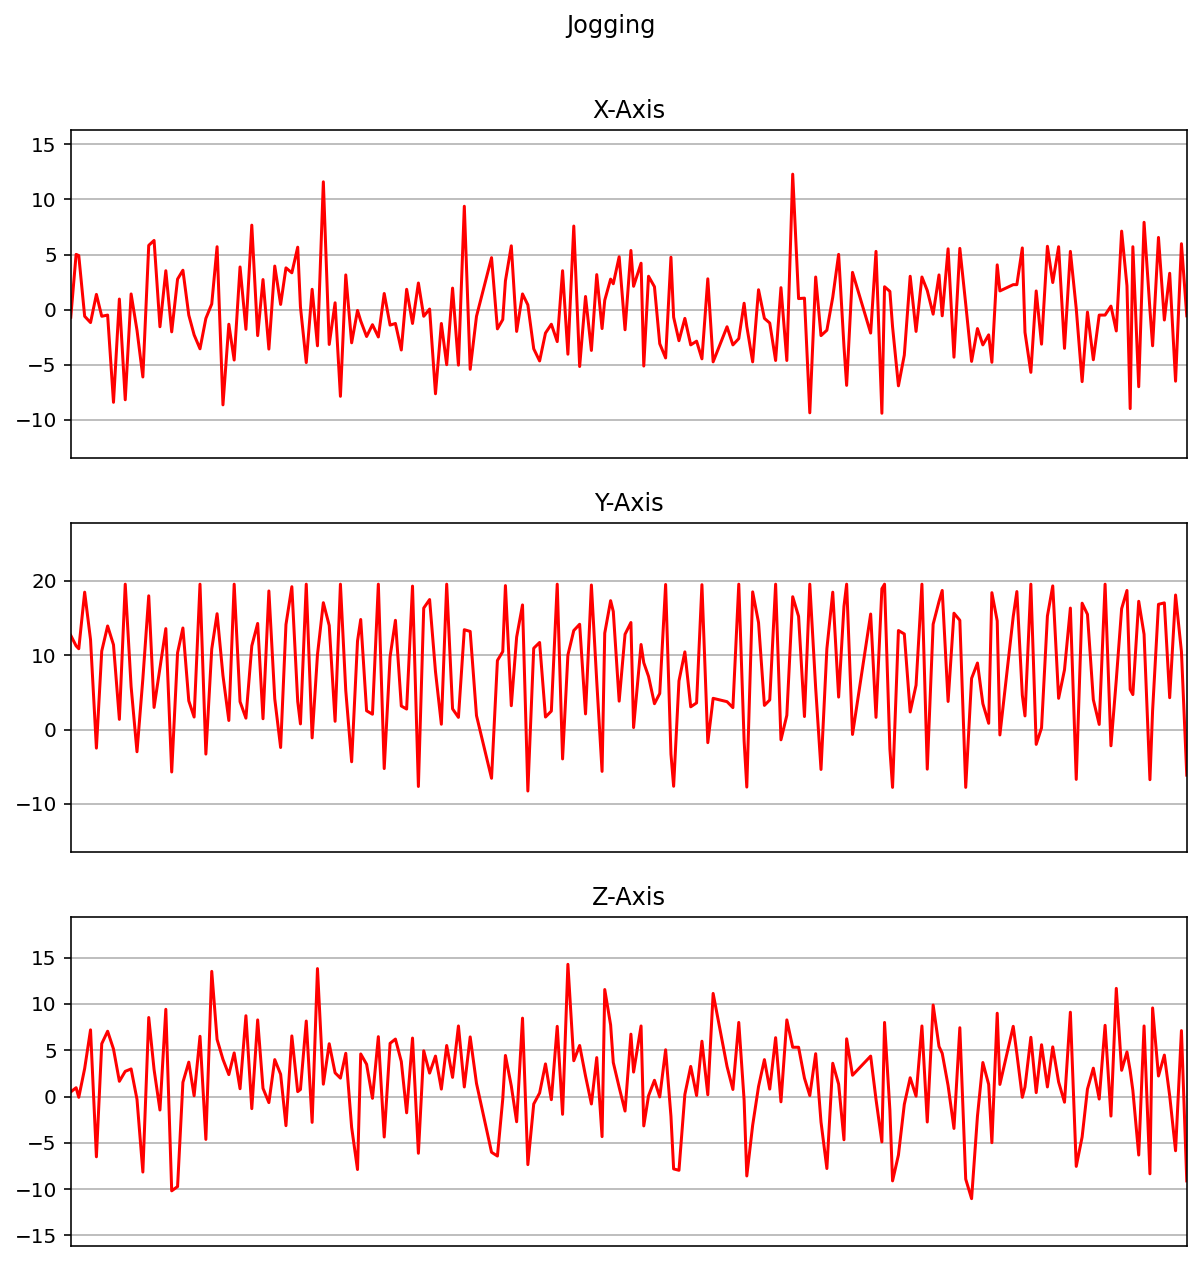

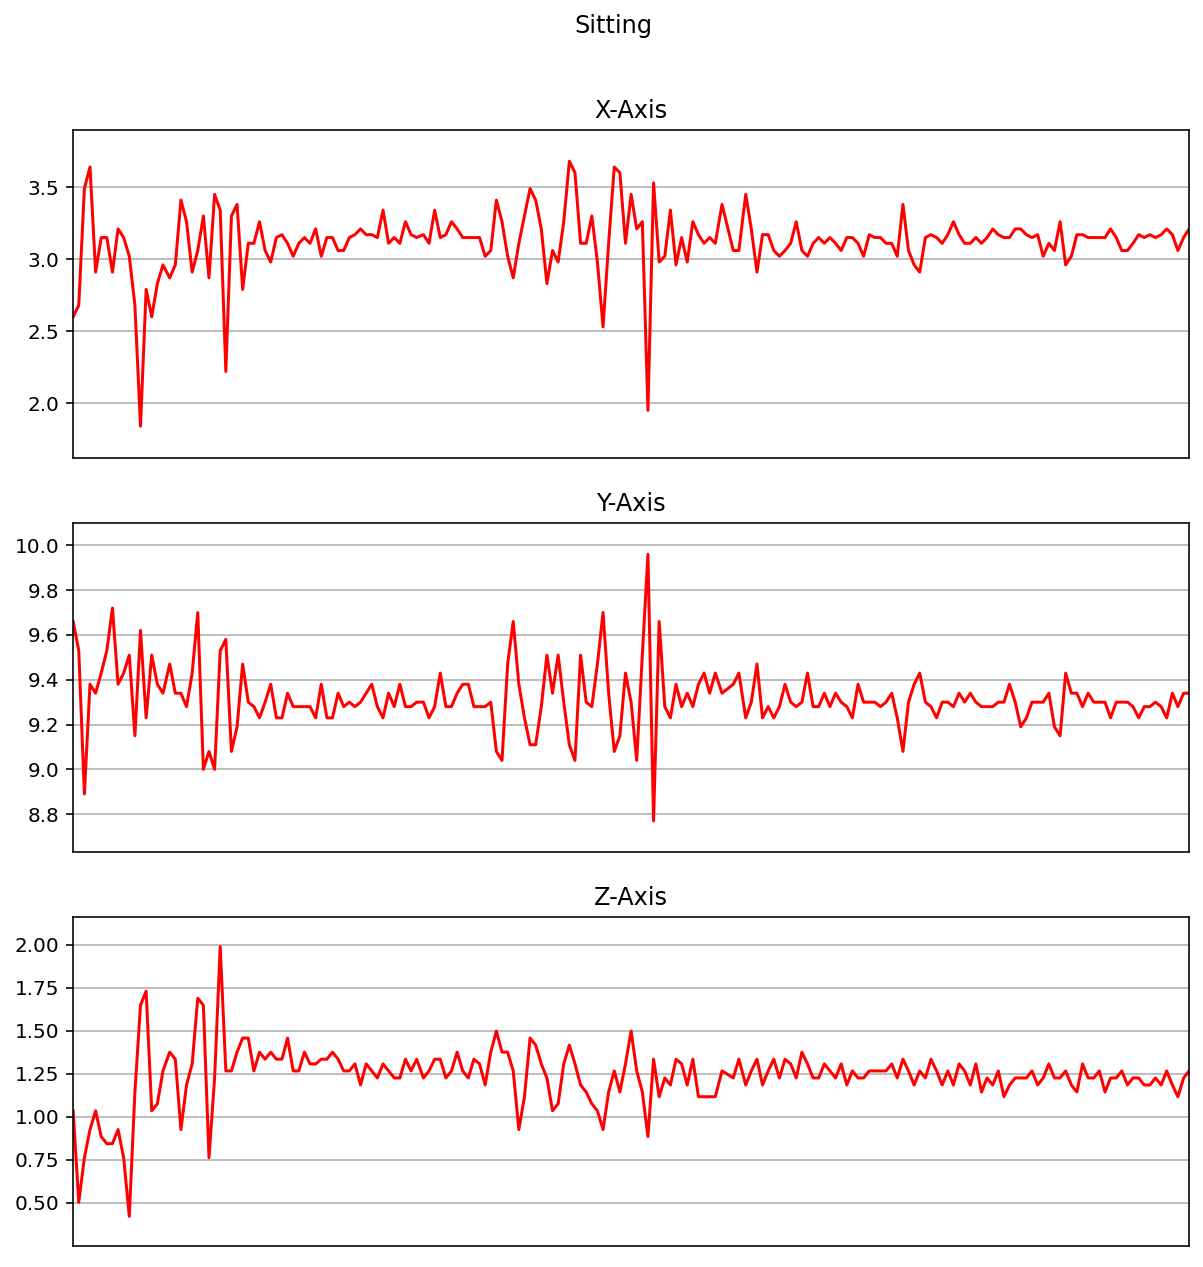

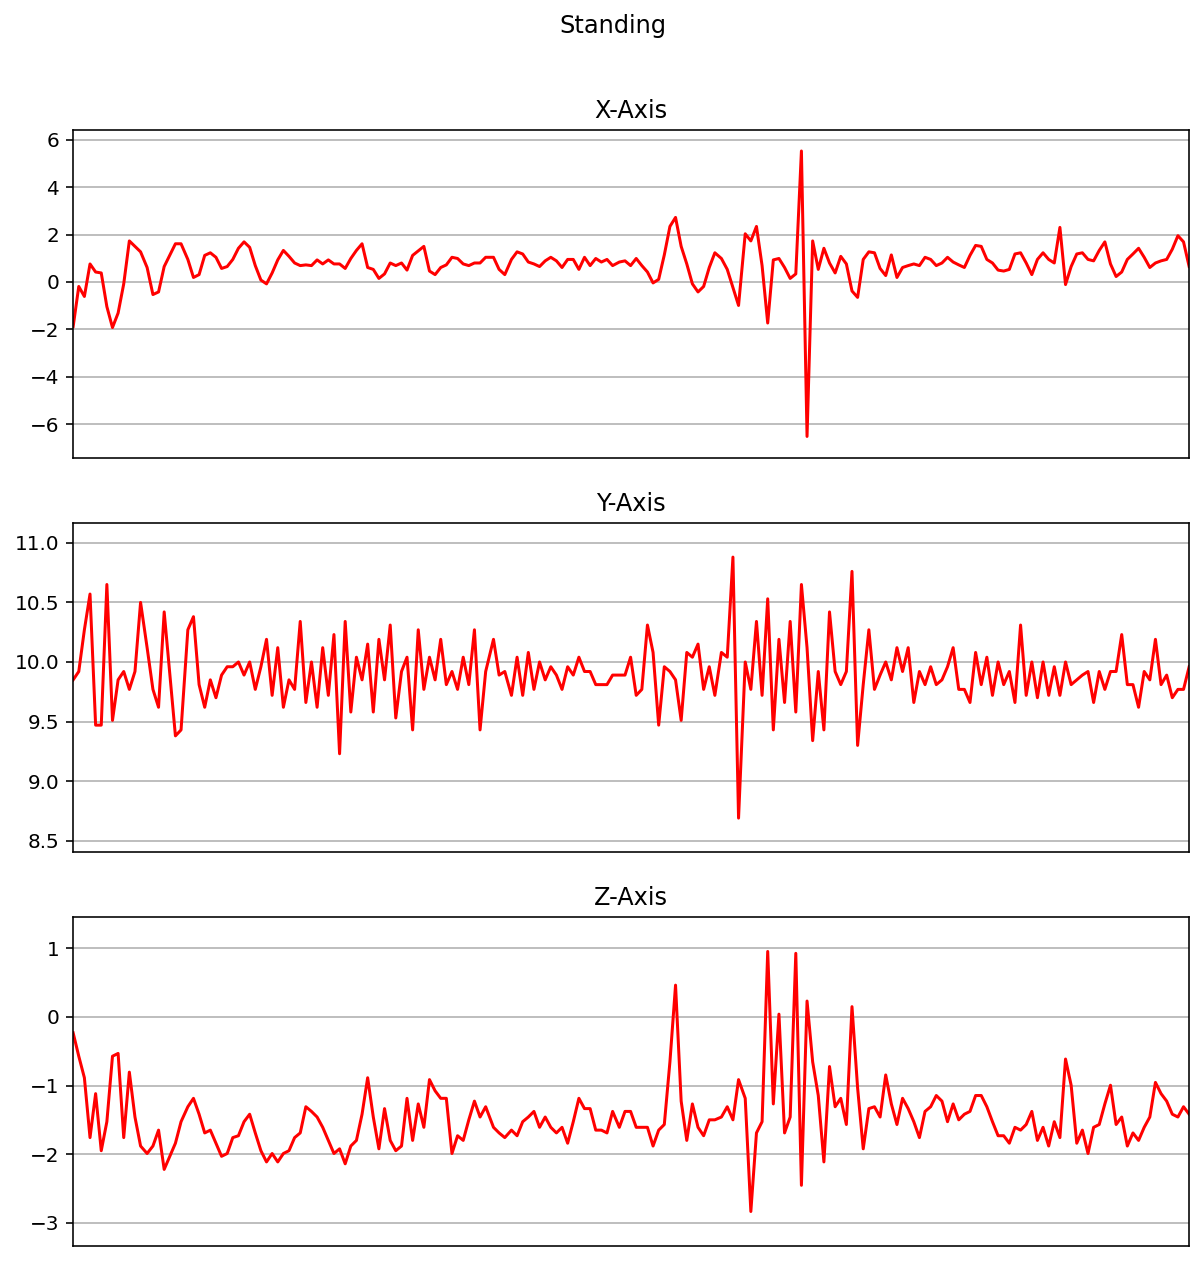

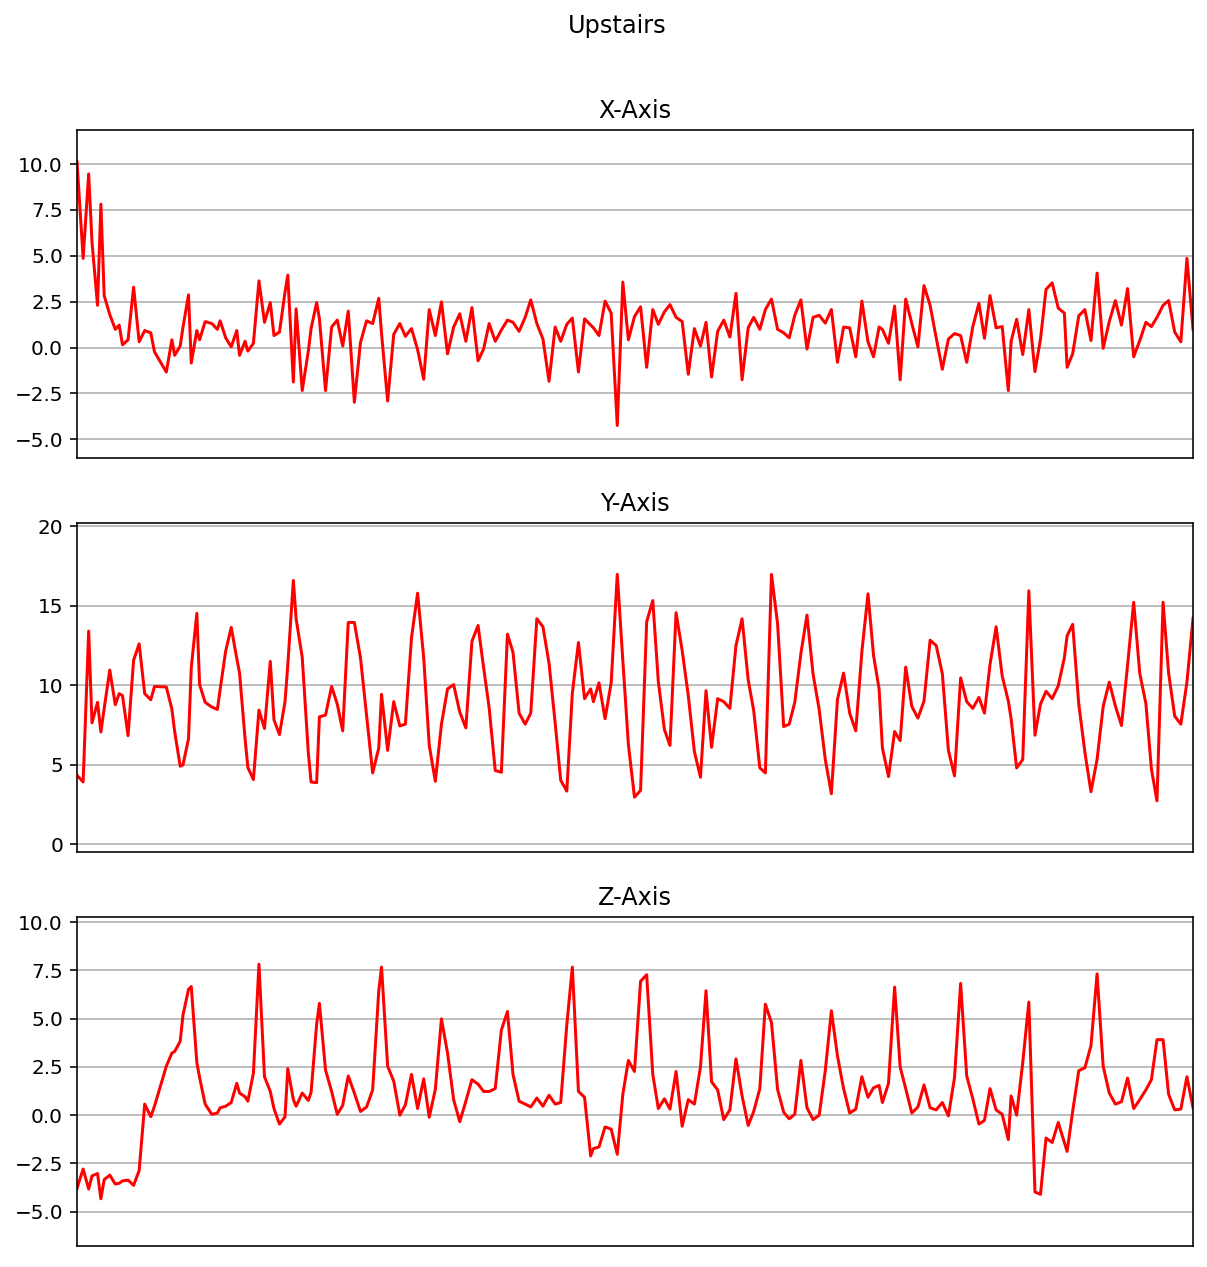

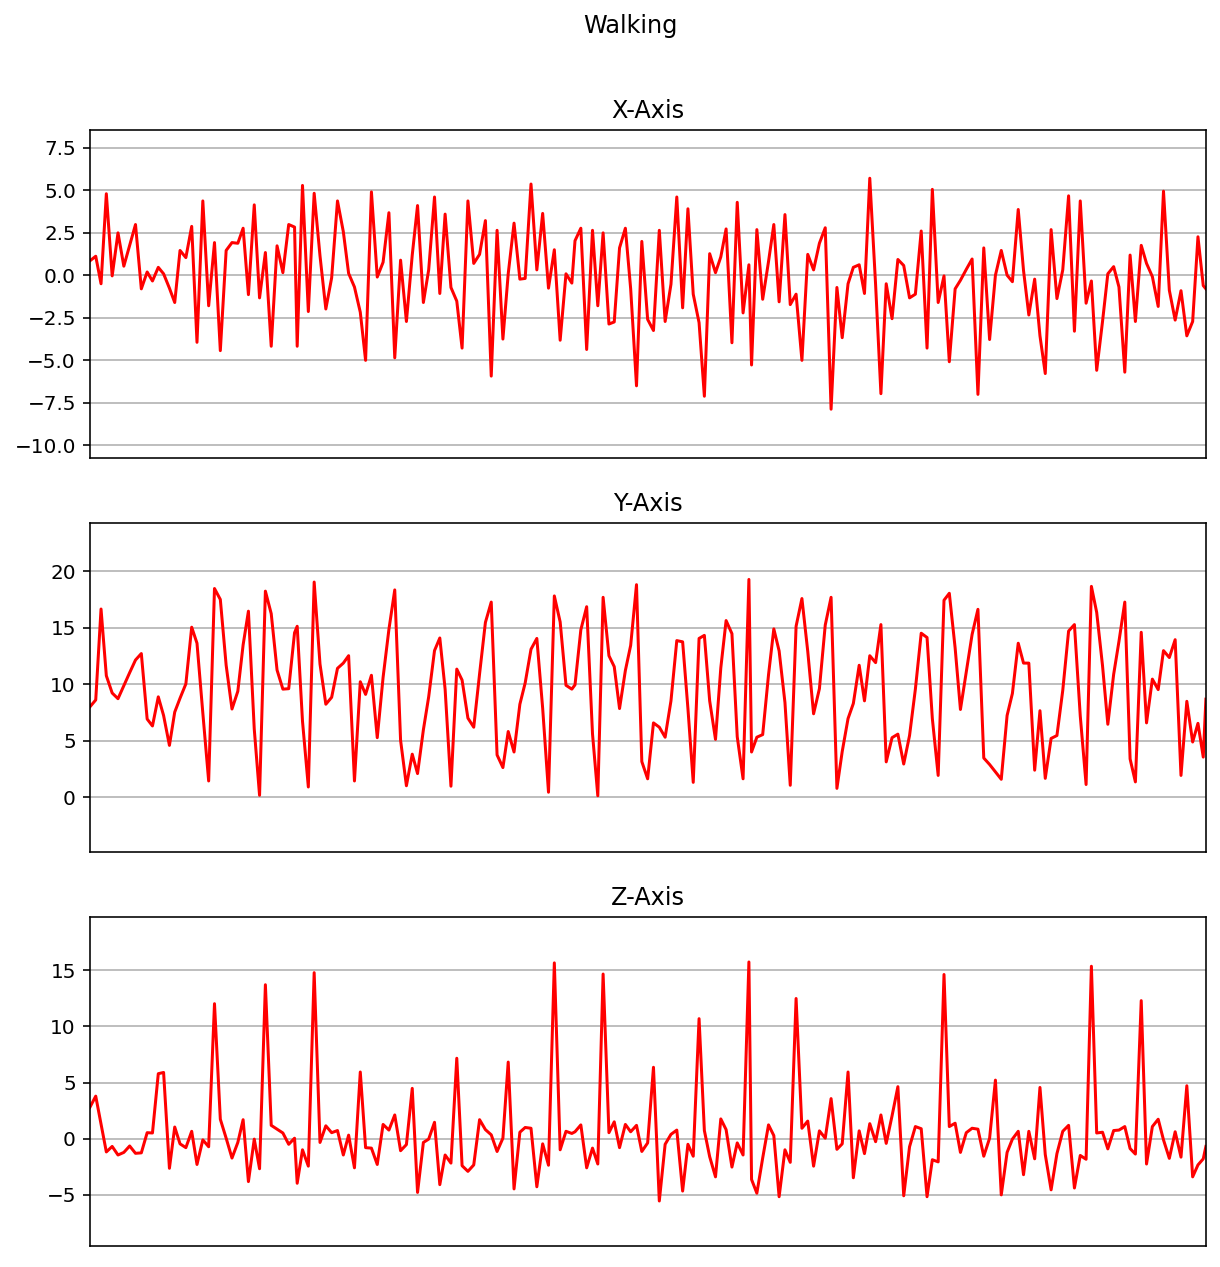

In [18]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10,10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:200]
    plot_activity(activity, subset)

In [19]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)

In [20]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


# 일정 기간동안 (윈도우)의 행동이 유지되는 것을 파악
- 현재 샘플링 시간은 50ms임
- 윈도우 크기를 100으로 잡으면 5초 동안 동일한 행동을 유지하는 경우만 취하게 됨
- stat 모듈이 제공하는 mode() 함수를 사용하여 최빈값을 구하고 이것이 100 인 경우의 데이터만 사용함 (동일한 행동을 5초간 유지하였는지를 파악함)

In [21]:
test = [1,1,1,1,1,1,1,1,1,1,1,1,2,2]
m = stats.mode(test) # 최빈값
m

ModeResult(mode=array([1]), count=array([12]))

In [22]:
m[1][0]

12

In [23]:
m[0][0], m[1][0]

(1, 12)

In [24]:
z = stats.mode(df['act'][100:200]) # 5초간 관찰
z[0][0], z[1][0]

(1, 100)

## 스케일링

In [25]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [26]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.198190,0.792216,0.018408,1
1,33,Jogging,49106062271000,0.630212,0.582032,0.112401,1
2,33,Jogging,49106112167000,0.614395,0.525444,-0.104069,1
3,33,Jogging,49106222305000,-0.186327,1.655184,0.545341,1
4,33,Jogging,49106332290000,-0.269365,0.707334,1.419766,1


## 훈련 데이터 검증 데이터 나누기
- 사용자를 기준으로 나누는 경우

In [27]:
(df['user-id'] < 28).mean()

0.7410978845728606

In [28]:
(df['user-id'] >= 28).mean()

0.25890211542713937

In [29]:
df_train = df[df['user-id'] < 28]
df_test = df[df['user-id'] >= 28]
# 랜덤하게 사용자를 선택하려면 choice() 사용

In [30]:
def get_xy(N, df): # N  윈도우 크기 (100)
    X, y = [], []
    for i in range(0, len(df)-N+1, N):
        z = stats.mode(df['act'][i: i+N])
        action, count = z[0][0], z[1][0]
        if count == N:
            xs = df['x-axis'].values[i: i + N]
            ys = df['y-axis'].values[i: i + N]
            zs = df['z-axis'].values[i: i + N]
            X.append(np.array([xs, ys, zs]).T)
            y.append(action)
    return np.array(X), np.array(y)

In [31]:
N = 100
X_train, y_train = get_xy(N, df_train)

In [32]:
X_test, y_test = get_xy(N, df_test)

In [33]:
X_train.shape, X_test.shape

((7752, 100, 3), (2713, 100, 3))

In [34]:
y_train.shape, y_test.shape

((7752,), (2713,))

In [35]:
# X_train[:1]

In [36]:
y_train[:3]

array([5, 5, 5])

In [37]:
def show_confusion_matrix(y_test, y_pred):
    matrix = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [38]:
def show_results(y_test, y_pred):
    show_confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))   

# 선형 분류

In [39]:
lin = SGDClassifier()
lin.fit(X_train.reshape(-1,300), y_train)
lin.score(X_test.reshape(-1,300), y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


0.41540729819388134

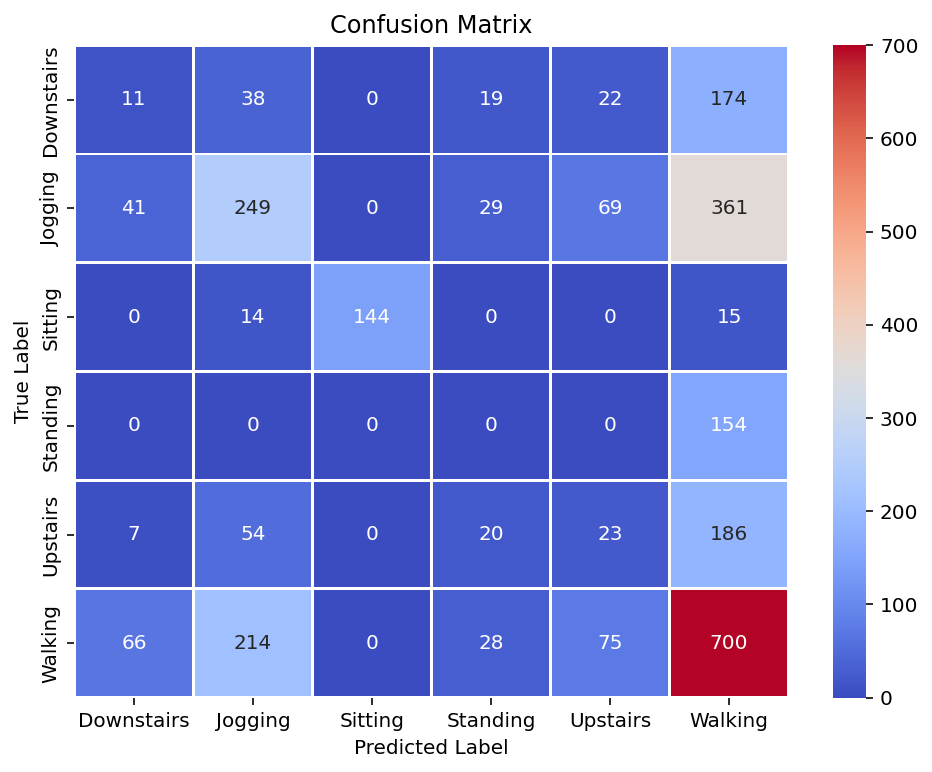

              precision    recall  f1-score   support

           0       0.09      0.04      0.06       264
           1       0.44      0.33      0.38       749
           2       1.00      0.83      0.91       173
           3       0.00      0.00      0.00       154
           4       0.12      0.08      0.10       290
           5       0.44      0.65      0.52      1083

    accuracy                           0.42      2713
   macro avg       0.35      0.32      0.33      2713
weighted avg       0.38      0.42      0.39      2713



In [44]:
y_pred = lin.predict(X_test.reshape(-1,300))
show_results(y_test, y_pred)

## 랜덤 포레스트

In [46]:
rfc = RandomForestClassifier() 
# rfc.fit(X_train.reshape(-1,300), y_train_cat)
# rfc.score(X_test.reshape(-1,300), y_test_cat)
rfc.fit(X_train.reshape(-1,300), y_train)
rfc.score(X_test.reshape(-1,300), y_test)

0.7401400663472171

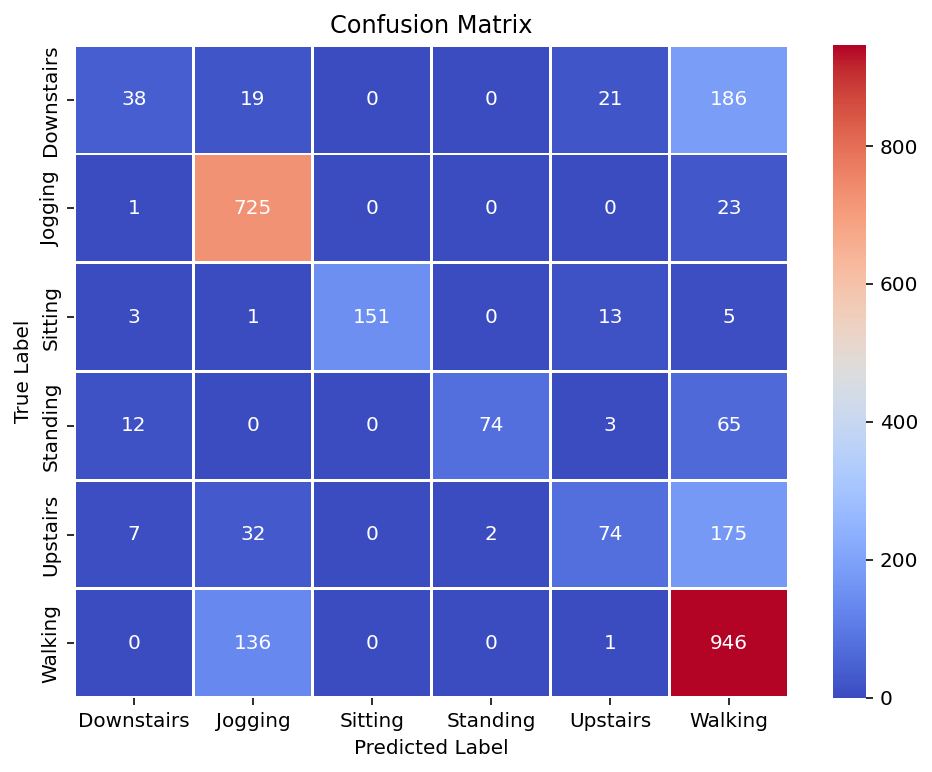

              precision    recall  f1-score   support

           0       0.62      0.14      0.23       264
           1       0.79      0.97      0.87       749
           2       1.00      0.87      0.93       173
           3       0.97      0.48      0.64       154
           4       0.66      0.26      0.37       290
           5       0.68      0.87      0.76      1083

    accuracy                           0.74      2713
   macro avg       0.79      0.60      0.64      2713
weighted avg       0.74      0.74      0.70      2713



In [47]:
y_pred = rfc.predict(X_test.reshape(-1,300))
show_results(y_test, y_pred)

# 목적변수를 원핫 인코딩으로 변경

In [48]:
# 원 핫 인코딩
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)
y_train_cat[:3]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

# MLP

In [88]:
model_m = Sequential()
model_m.add(Reshape((N*3,),input_shape=(N,3)))
model_m.add(Dense(200, activation='relu',input_shape=(N*3,)))
model_m.add(Dropout(0.5))
model_m.add(Dense(200, activation='relu'))
model_m.add(Dropout(0.5))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))
# model_m.summary()

In [89]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# 레이블로 원 핫 인코딩을 사용해야 한다
h = model_m.fit(X_train,
                      y_train_cat,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=0)

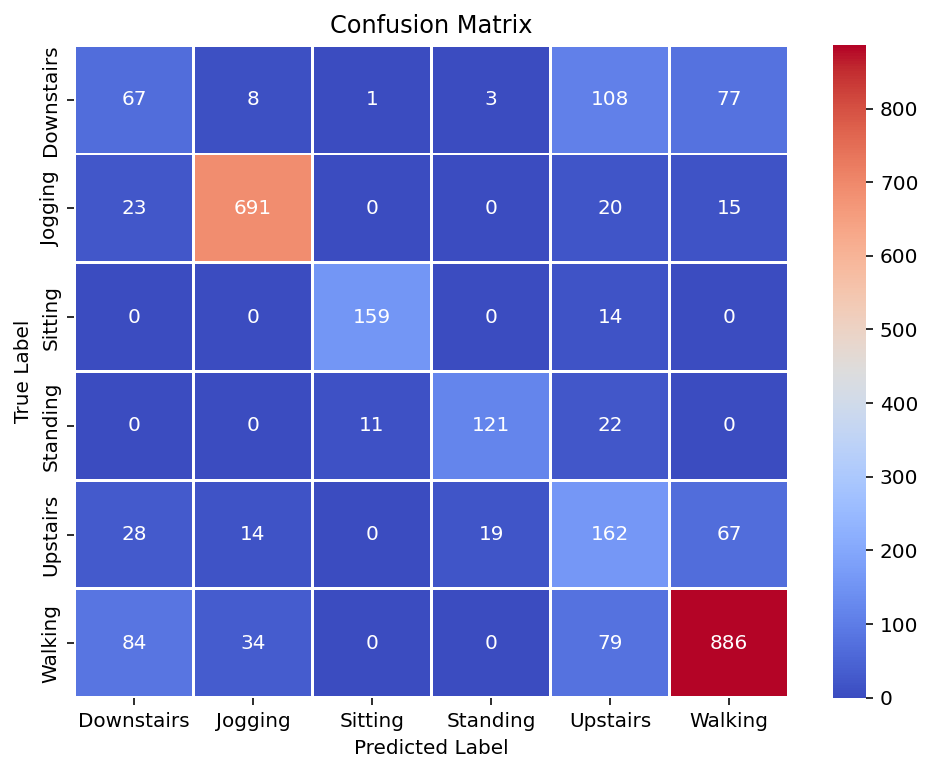

              precision    recall  f1-score   support

           0       0.33      0.25      0.29       264
           1       0.93      0.92      0.92       749
           2       0.93      0.92      0.92       173
           3       0.85      0.79      0.81       154
           4       0.40      0.56      0.47       290
           5       0.85      0.82      0.83      1083

    accuracy                           0.77      2713
   macro avg       0.71      0.71      0.71      2713
weighted avg       0.78      0.77      0.77      2713



In [90]:
y_pred = model_m.predict(X_test)

# 원핫 인코딩을 레이블 인코딩으로 변환
max_y_pred = np.argmax(y_pred, axis=1)
show_results(y_test, max_y_pred)

In [91]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

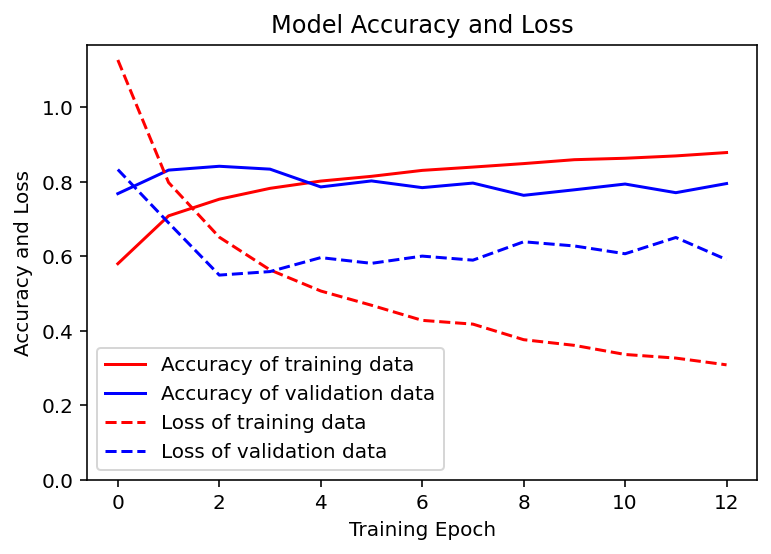

In [92]:
show_4_graphs(h)

# CNN (Conv1D)

In [136]:
# (sample, shape, features) 구조 사용
model_cnn = Sequential()
model_cnn.add(Conv1D(32, 4, activation='relu',input_shape=(N,3)))
model_cnn.add(Dropout(0.3))
model_cnn.add(Conv1D(32, 4, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, 4, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, 4, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(6, activation='softmax'))
model_cnn.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 97, 32)            416       
                                                                 
 dropout_37 (Dropout)        (None, 97, 32)            0         
                                                                 
 conv1d_33 (Conv1D)          (None, 94, 32)            4128      
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 47, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_34 (Conv1D)          (None, 44, 64)            8256      
                                                                 
 dropout_38 (Dropout)        (None, 44, 64)            0         
                                                     

In [137]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]
model_cnn.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_cnn.fit(X_train,
                      y_train_cat,
                      batch_size=30,
                      epochs=50,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
207/207 [==============================] - 2s 6ms/step - loss: 0.7684 - accuracy: 0.7007 - val_loss: 0.6462 - val_accuracy: 0.7840
Epoch 2/50
207/207 [==============================] - 1s 5ms/step - loss: 0.3512 - accuracy: 0.8679 - val_loss: 0.7198 - val_accuracy: 0.7917
Epoch 3/50
207/207 [==============================] - 1s 5ms/step - loss: 0.2502 - accuracy: 0.9061 - val_loss: 0.7724 - val_accuracy: 0.7950
Epoch 4/50
207/207 [==============================] - 1s 5ms/step - loss: 0.2044 - accuracy: 0.9228 - val_loss: 0.8971 - val_accuracy: 0.7666
Epoch 5/50
207/207 [==============================] - 1s 5ms/step - loss: 0.1457 - accuracy: 0.9474 - val_loss: 0.9438 - val_accuracy: 0.7988
Epoch 6/50
207/207 [==============================] - 1s 5ms/step - loss: 0.1278 - accuracy: 0.9581 - val_loss: 0.9507 - val_accuracy: 0.7730
Epoch 7/50
207/207 [==============================] - 1s 5ms/step - loss: 0.1055 - accuracy: 0.9648 - val_loss: 1.1194 - val_accuracy: 0.7595
Epoch 

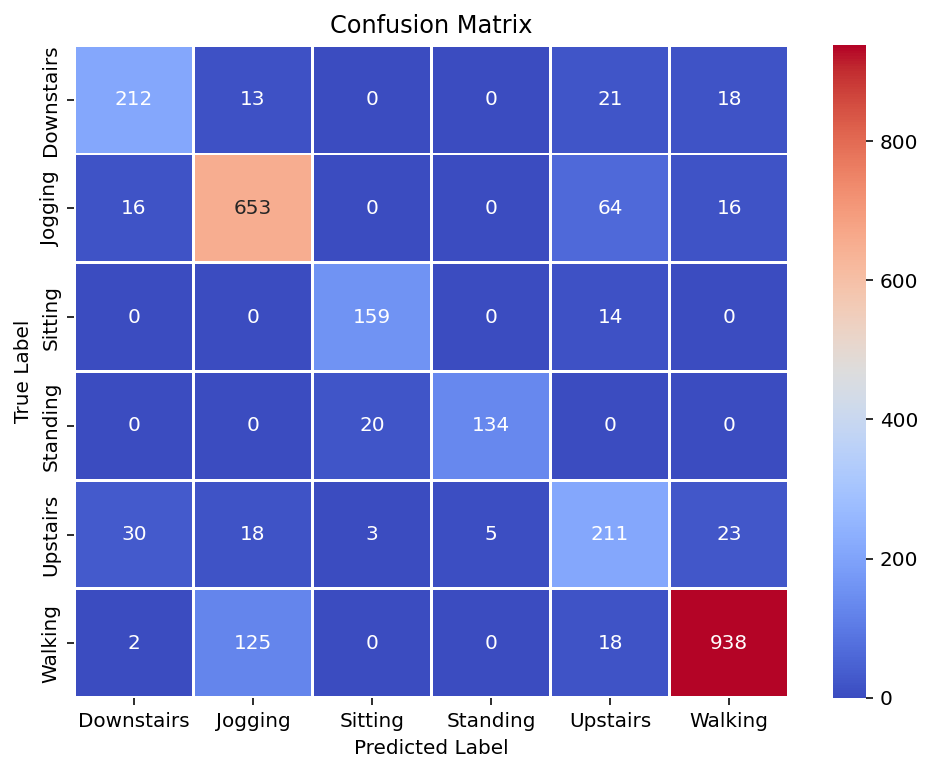

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       264
           1       0.81      0.87      0.84       749
           2       0.87      0.92      0.90       173
           3       0.96      0.87      0.91       154
           4       0.64      0.73      0.68       290
           5       0.94      0.87      0.90      1083

    accuracy                           0.85      2713
   macro avg       0.84      0.84      0.84      2713
weighted avg       0.86      0.85      0.85      2713



In [138]:
y_pred = model_cnn.predict(X_test)

# 원핫 인코딩을 레이블 인코딩으로 변환
max_y_pred = np.argmax(y_pred, axis=1)
show_results(y_test, max_y_pred)

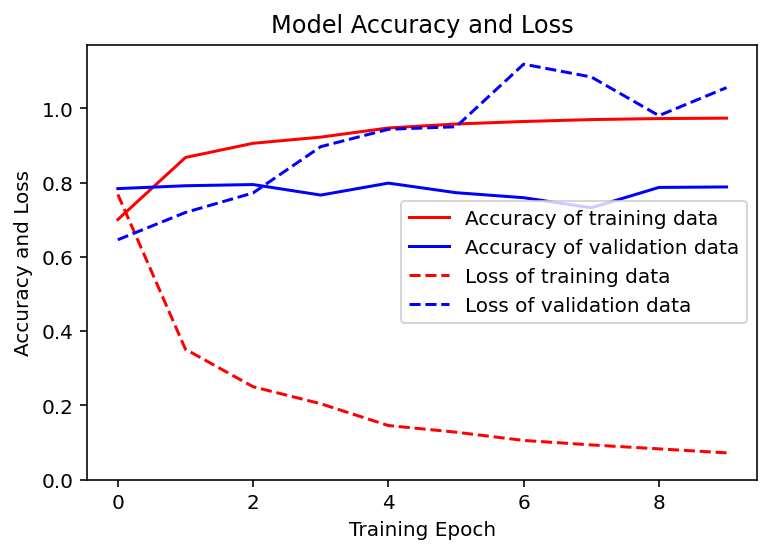

In [139]:
show_4_graphs(history)

# RNN

In [128]:
from keras.layers import GRU
model_rnn = Sequential()
model_rnn.add(GRU(256, return_sequences=True, input_shape=(N,3)))
model_rnn.add(Dropout(0.2))
model_rnn.add(GRU(256))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(6, activation='softmax'))

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
model_rnn.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100, 256)          200448    
                                                                 
 dropout_32 (Dropout)        (None, 100, 256)          0         
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dropout_33 (Dropout)        (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 596,742
Trainable params: 596,742
Non-trainable params: 0
_________________________________________________________________


In [129]:
history = model_rnn.fit(X_train,
                      y_train_cat,
                      batch_size=30,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
207/207 [==============================] - 9s 18ms/step - loss: 0.8010 - accuracy: 0.7171 - val_loss: 0.4664 - val_accuracy: 0.8472
Epoch 2/30
207/207 [==============================] - 3s 15ms/step - loss: 0.3200 - accuracy: 0.8781 - val_loss: 0.7096 - val_accuracy: 0.7969
Epoch 3/30
207/207 [==============================] - 3s 16ms/step - loss: 0.2093 - accuracy: 0.9245 - val_loss: 0.5663 - val_accuracy: 0.8066
Epoch 4/30
207/207 [==============================] - 3s 15ms/step - loss: 0.1192 - accuracy: 0.9586 - val_loss: 0.8559 - val_accuracy: 0.7550


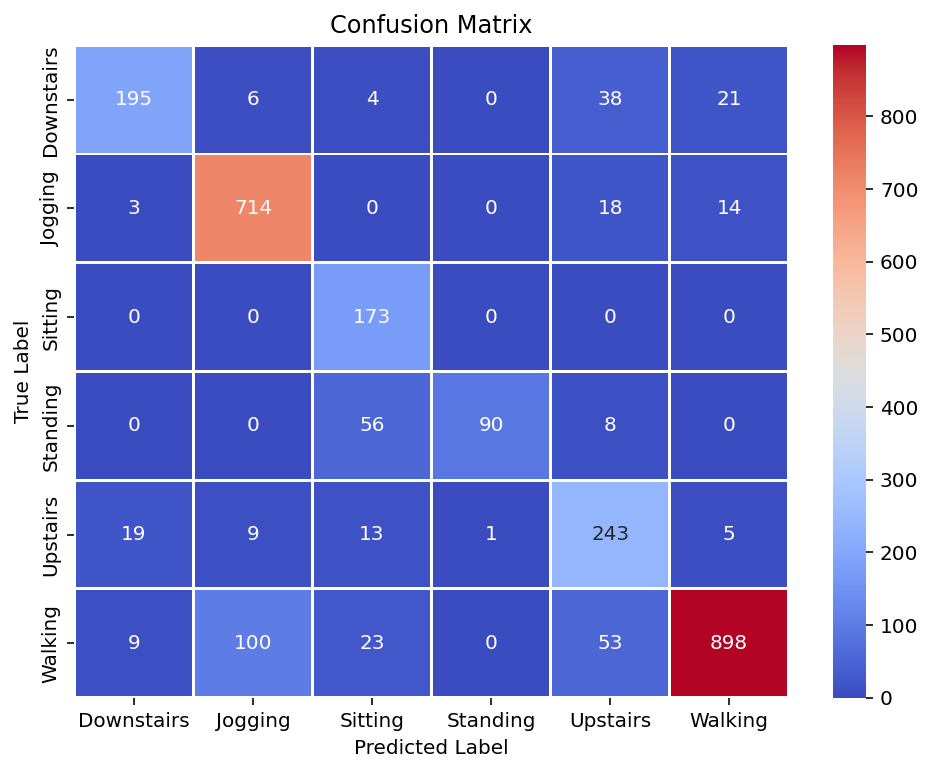

              precision    recall  f1-score   support

           0       0.86      0.74      0.80       264
           1       0.86      0.95      0.90       749
           2       0.64      1.00      0.78       173
           3       0.99      0.58      0.73       154
           4       0.68      0.84      0.75       290
           5       0.96      0.83      0.89      1083

    accuracy                           0.85      2713
   macro avg       0.83      0.82      0.81      2713
weighted avg       0.87      0.85      0.85      2713



In [130]:
y_pred = model_rnn.predict(X_test)

# 원핫 인코딩을 레이블 인코딩으로 변환
max_y_pred = np.argmax(y_pred, axis=1)
show_results(y_test, max_y_pred)

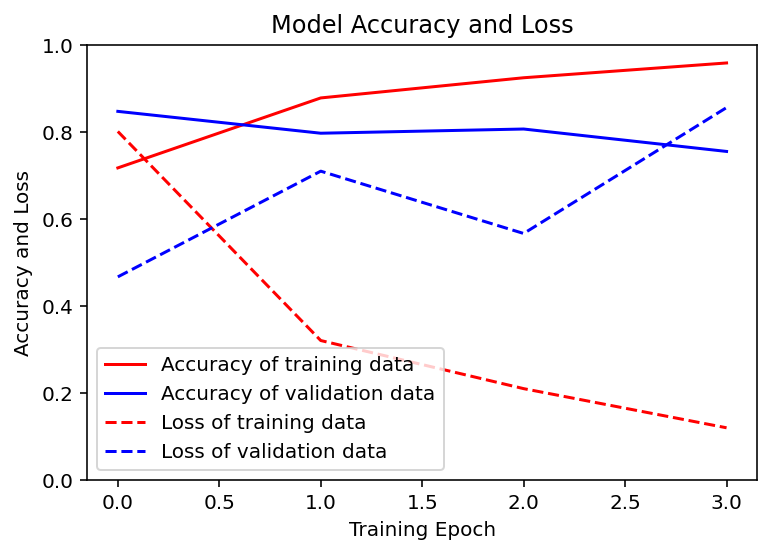

In [131]:
show_4_graphs(history)